# Real Estate Portfolio Analysis

## Notebook Initialization and Configuration

### Add Imports

In [1]:
import pandas as pd
import alpaca_trade_api as tradeapi
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
from MCForecastTools import MCSimulation


### Add Configuration

In [2]:
NUM_TRADING_DAYS = 252
NUM_SIMULATIONS = 1000
TICKERS = ['AMT', 'PLD', 'CCI', 'EQIX', 'PSA']
TIMEFRAME = '1D'
START_DATE_ET = '2018-01-01'
END_DATE_ET = '2021-11-05'
EXAMPLE_INVESTMENT = 10000

## Retrieve, Prepare, and Store Data

### Intialize Alpaca Trading API Client

In [3]:
# NOTE: Must have the APCA_API_KEY_ID and APCA_API_SECRET_KEY
# environment variables configured in the OS or in a .env file.
# Environment variables with this name are looked up by default
# by Alpaca.

load_dotenv()
alpaca = tradeapi.REST()

### Retrieve and Store Raw Data

In [4]:
start_date = pd.Timestamp(START_DATE_ET, tz='America/New_York').isoformat()
end_date = pd.Timestamp(END_DATE_ET, tz='America/New_York').isoformat()

prices_df = alpaca.get_barset(
                        symbols=TICKERS,
                        timeframe=TIMEFRAME,
                        limit=1000,
                        start=start_date,
                        end=end_date).df

prices_df.to_csv(Path('../data/real_estate_raw.csv'))

### Clean and Store data

In [5]:
#Check for non-float data types and missing data
display(prices_df.dtypes)
display(prices_df.isnull().sum())

prices_df = prices_df.dropna()
display(prices_df.isnull().sum())

prices_df.to_csv(Path('../data/real_estate_clean.csv'))

AMT   open      float64
      high      float64
      low       float64
      close     float64
      volume    float64
CCI   open      float64
      high      float64
      low       float64
      close     float64
      volume    float64
EQIX  open      float64
      high      float64
      low       float64
      close     float64
      volume    float64
PLD   open      float64
      high      float64
      low       float64
      close     float64
      volume    float64
PSA   open      float64
      high      float64
      low       float64
      close     float64
      volume    float64
dtype: object

AMT   open      1
      high      1
      low       1
      close     1
      volume    1
CCI   open      2
      high      2
      low       2
      close     2
      volume    2
EQIX  open      1
      high      1
      low       1
      close     1
      volume    1
PLD   open      1
      high      1
      low       1
      close     1
      volume    1
PSA   open      1
      high      1
      low       1
      close     1
      volume    1
dtype: int64

AMT   open      0
      high      0
      low       0
      close     0
      volume    0
CCI   open      0
      high      0
      low       0
      close     0
      volume    0
EQIX  open      0
      high      0
      low       0
      close     0
      volume    0
PLD   open      0
      high      0
      low       0
      close     0
      volume    0
PSA   open      0
      high      0
      low       0
      close     0
      volume    0
dtype: int64

## Analyze Data

### Calculate Daily Returns (aggregated)

In [6]:
closing_prices_df = prices_df.xs('close',axis='columns',level=1)

daily_returns_df = closing_prices_df.sum(axis=1).pct_change().dropna()

print('DAILY RETURNS')
print('=============')
daily_returns_df

DAILY RETURNS


time
2018-01-03 00:00:00-05:00    0.002134
2018-01-04 00:00:00-05:00   -0.009190
2018-01-05 00:00:00-05:00   -0.003539
2018-01-08 00:00:00-05:00    0.018961
2018-01-09 00:00:00-05:00   -0.012539
                               ...   
2021-11-01 00:00:00-04:00   -0.003872
2021-11-02 00:00:00-04:00    0.010182
2021-11-03 00:00:00-04:00   -0.003233
2021-11-04 00:00:00-04:00   -0.021217
2021-11-05 00:00:00-04:00   -0.019934
Length: 966, dtype: float64

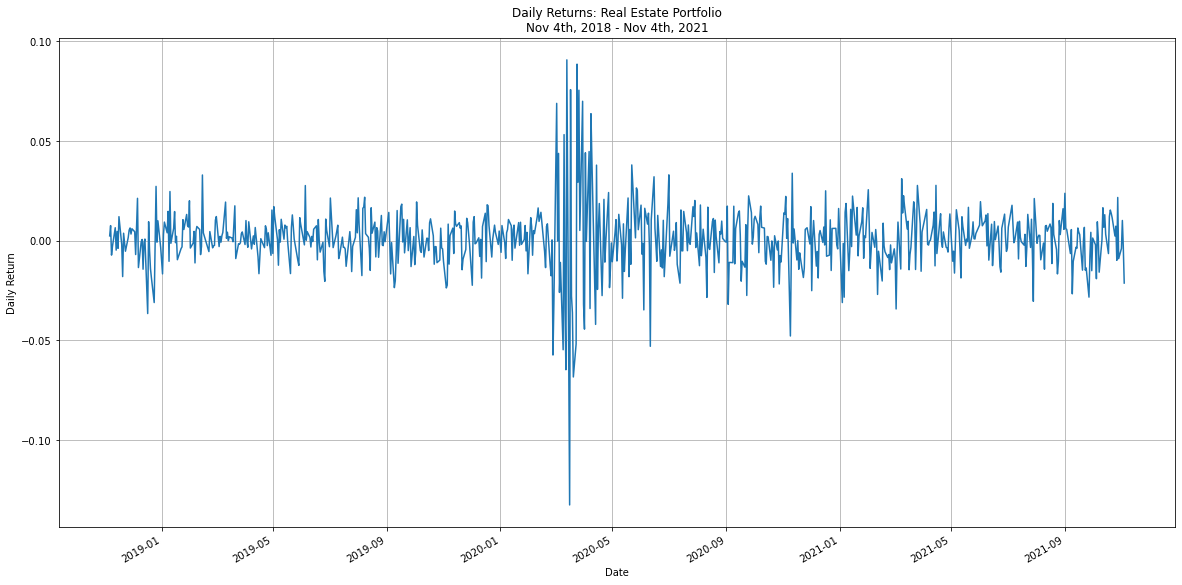

In [76]:
plot = daily_returns_df.plot(title='Daily Returns: Real Estate Portfolio\n'
                            'Nov 4th, 2018 - Nov 4th, 2021',
                            figsize=(20,10))
plot.set (xlabel='Date', ylabel='Daily Return')
plot.grid()

### Calculate Cumulative Return

In [7]:
cumulative_returns_df = (1 + daily_returns_df).cumprod() - 1

print('CUMULATIVE RETURNS')
print('==================')
cumulative_returns_df

CUMULATIVE RETURNS


time
2018-01-03 00:00:00-05:00    0.002134
2018-01-04 00:00:00-05:00   -0.007075
2018-01-05 00:00:00-05:00   -0.010590
2018-01-08 00:00:00-05:00    0.008171
2018-01-09 00:00:00-05:00   -0.004470
                               ...   
2021-11-01 00:00:00-04:00    0.829398
2021-11-02 00:00:00-04:00    0.848024
2021-11-03 00:00:00-04:00    0.842050
2021-11-04 00:00:00-04:00    0.802968
2021-11-05 00:00:00-04:00    0.767028
Length: 966, dtype: float64

In [ ]:
cumulative_returns_df.to_csv(Path('../data/cum_returns_real_estate.csv'))

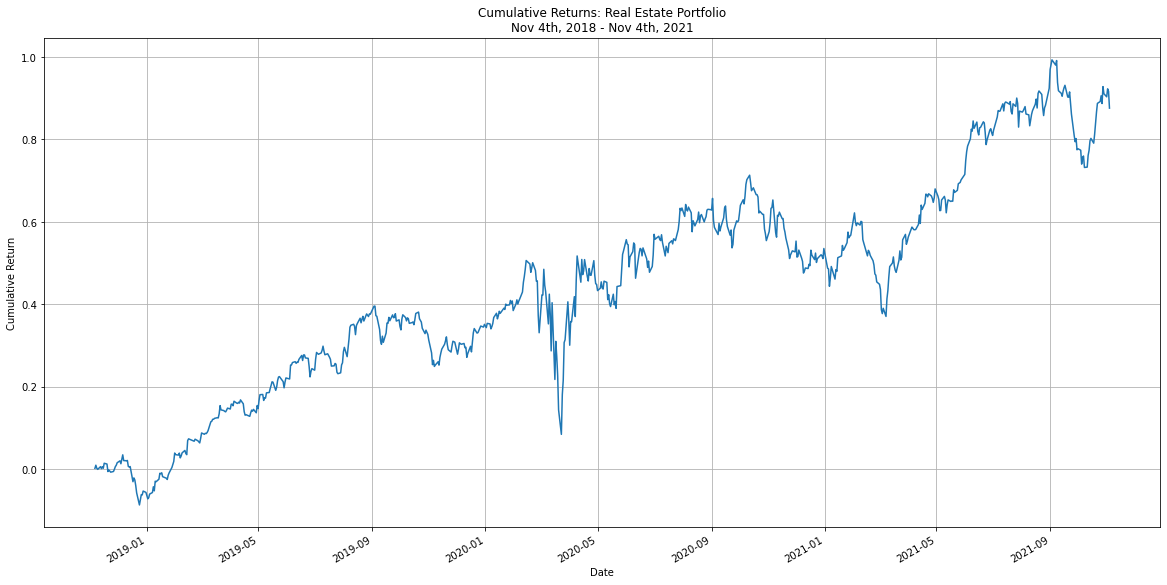

In [87]:
plot = cumulative_returns_df.plot(title='Cumulative Returns: Real Estate Portfolio\n'
                                'Nov 4th, 2018 - Nov 4th, 2021',
                                figsize=(20,10))
plot.set (xlabel='Date', ylabel='Cumulative Return')
plot.grid()

### Analyze the Volatility

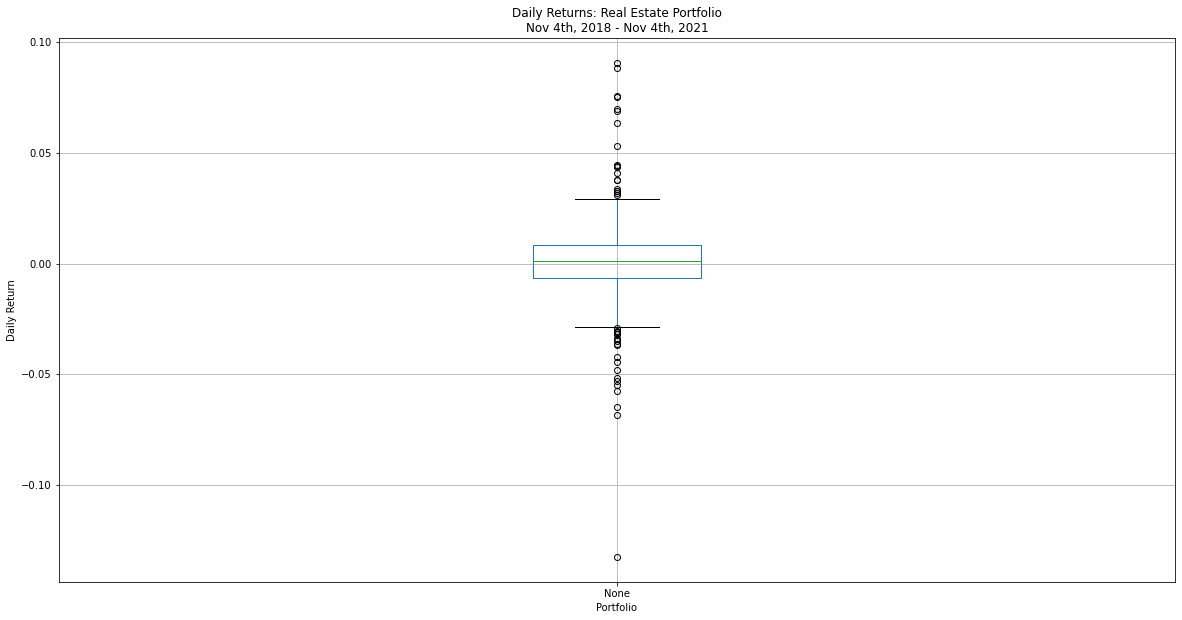

In [79]:
plot = daily_returns_df.plot(kind='box',
                        title='Daily Returns: Real Estate Portfolio\n'
                        'Nov 4th, 2018 - Nov 4th, 2021',
                        figsize=(20,10))
plot.set (xlabel='Portfolio', ylabel='Daily Return')
plot.grid()

### Analyze the Risk

In [80]:
daily_returns_std_df = daily_returns_df.std()
print('DAILY RETURNS STANDARD DEVIATION')
print('================================')
daily_returns_std_df

DAILY RETURNS STANDARD DEVIATION


0.016344047517188633

In [81]:
daily_returns_annualized_std_df = daily_returns_df.std() * np.sqrt(NUM_TRADING_DAYS)
print('ANNUALIZED STANDARD DEVIATION')
print('=============================')
daily_returns_annualized_std_df

ANNUALIZED STANDARD DEVIATION


0.2594537108802228

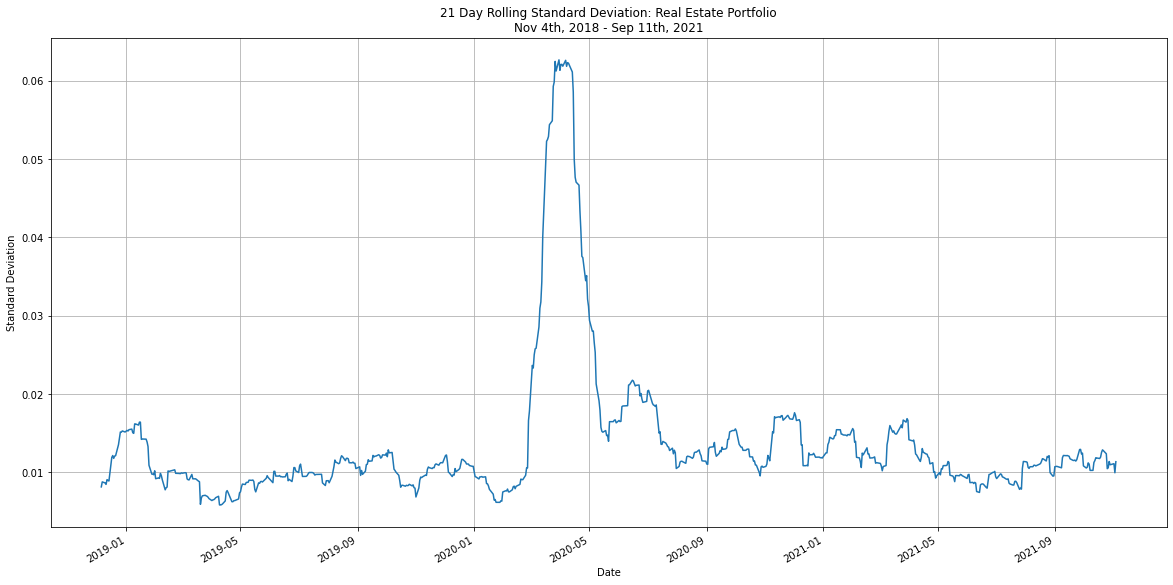

In [82]:
daily_returns_std_21_df = daily_returns_df.rolling(window=21).std()
plot = daily_returns_std_21_df.plot(title='21 Day Rolling Standard Deviation: Real Estate Portfolio\n'
                                        'Nov 4th, 2018 - Sep 11th, 2021',
                                        figsize=(20,10))
plot.set (xlabel='Date', ylabel='Standard Deviation')
plot.grid()

### Analyze the Risk-Return Profile

In [83]:
average_annual_return_df = daily_returns_df.mean() * NUM_TRADING_DAYS
print("AVERAGE ANNUAL RETURN")
print("=====================")
average_annual_return_df

AVERAGE ANNUAL RETURN


0.24463881127031578

In [52]:
sharpe_ratio = average_annual_return_df / daily_returns_annualized_std_df
print("SHARPE RATIO")
print("=============")
sharpe_ratio

SHARPE RATIO


0.9424540040148895

### Run 10 Year Monte Carlo Simulation

In [53]:
years = 10
# weights default to being split evenly if not passed
mc = MCSimulation(
                portfolio_data = prices_df,
                num_simulation = NUM_SIMULATIONS,
                num_trading_days = NUM_TRADING_DAYS * years)

mc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998262,0.993413,1.008377,1.015642,0.994404,1.016080,0.997612,1.004314,0.994727,1.003495,...,1.006587,0.983803,1.009433,0.999981,0.991653,0.999642,0.989968,1.011392,0.999018,1.010730
2,0.990807,0.999044,0.995329,1.032068,1.000475,1.011493,1.005176,1.023262,1.008785,1.003567,...,1.007207,0.981858,1.009883,1.000648,0.990102,1.002947,1.003594,1.015150,0.990036,1.005576
3,0.997038,1.000218,0.998119,1.034119,1.006851,1.004007,1.006162,1.015754,1.010064,0.993745,...,1.014878,0.989220,1.025976,1.013027,0.998615,0.997838,1.005170,1.016213,0.994761,1.006375
4,0.983838,1.012577,1.012160,1.020465,1.015107,0.992921,1.011031,1.022926,1.017026,1.000923,...,1.022050,1.003203,1.042199,1.016122,1.002192,0.998608,1.012353,1.031501,0.996044,0.999900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,3.396340,17.746713,9.971062,15.226689,7.018327,12.650905,12.553122,8.469100,8.388632,12.364456,...,10.384605,10.414818,6.045625,6.370744,14.641414,8.138008,20.947083,14.121929,18.634493,8.404496
2517,3.388381,17.734531,10.055486,15.276668,7.113243,12.732720,12.523383,8.630429,8.300166,12.340996,...,10.419160,10.432171,6.006931,6.333228,14.590799,8.177457,20.999486,14.267842,18.689680,8.362218
2518,3.362174,17.588116,10.031914,15.160443,7.179299,12.597787,12.478634,8.684709,8.378492,12.307704,...,10.401114,10.355119,5.957176,6.325927,14.511228,8.217926,21.148739,14.268062,18.874019,8.367460
2519,3.351626,17.698113,10.068157,14.965071,7.254313,12.454372,12.486093,8.714390,8.437647,12.381080,...,10.353303,10.259065,5.954373,6.361794,14.622139,8.301405,21.040285,14.221101,18.862471,8.383111


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

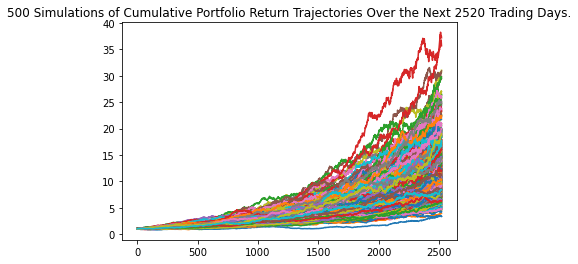

In [54]:
mc.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

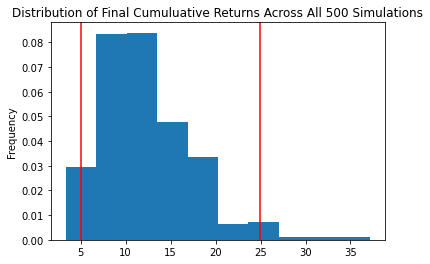

In [55]:
mc.plot_distribution()

### Calculate 10 Year Cumulative Returns

In [56]:
mc_cumulative_returns = mc.summarize_cumulative_return()
print(f'{years} year Monte Carlo summary statistics for Real Estate.')
print(mc_cumulative_returns)

10 year Monte Carlo summary statistics for Real Estate.
count           500.000000
mean             12.290511
std               5.124244
min               3.341088
25%               8.620403
50%              11.412237
75%              15.105729
max              37.188152
95% CI Lower      5.032902
95% CI Upper     24.913307
Name: 2520, dtype: float64


In [88]:
lower_return = mc_cumulative_returns[8] * EXAMPLE_INVESTMENT
upper_return = mc_cumulative_returns[9] * EXAMPLE_INVESTMENT

print(f"Using a 95% confidence interval, the expected return of the "
    f"real estate portfolio is between {mc_cumulative_returns[8]: ,.2f}% "
    f"and {mc_cumulative_returns[9]: ,.2f}%. An initial example "
    f"investment of ${EXAMPLE_INVESTMENT: ,.2f} would be worth between "
    f"${lower_return: ,.2f} and ${upper_return: ,.2f} in {years} years")

Using a 95% confidence interval, the expected return of the real estate portfolio is between  343.19% and  5,644.27%. An initial example investment of $ 10,000.00 would be worth between $ 3,431,892.95 and $ 56,442,677.48 in 30 years


### Run 30 year Monte Carlo Simulation 

In [60]:
years = 30
# weights default to being split evenly if not passed
mc = MCSimulation(
                portfolio_data = prices_df,
                num_simulation = NUM_SIMULATIONS,
                num_trading_days = NUM_TRADING_DAYS * years)

mc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.981757,1.004178,1.001115,1.002034,0.991910,1.006409,1.007073,0.993832,0.996966,1.003804,...,1.001555,0.996681,0.989379,0.995012,1.005690,1.000821,1.010769,0.995363,1.007025,0.995466
2,0.999617,1.006701,0.988131,0.995538,0.997231,1.003256,1.011963,1.008216,0.995147,0.998638,...,0.993069,1.000426,1.001367,0.982631,1.000869,0.997190,0.997085,0.992275,1.009982,0.997793
3,1.001336,0.998396,0.986003,0.997664,1.008692,0.999163,1.016513,1.008062,0.982711,0.993134,...,0.999539,1.000255,1.006075,0.986027,1.005948,1.007246,0.986591,1.002273,1.012371,1.003096
4,1.006754,1.002833,0.993888,1.012885,1.001038,0.997122,1.019046,1.012403,0.995446,0.979859,...,0.998864,1.004734,1.004479,0.978204,1.013075,1.014443,0.984364,0.988103,1.010142,0.997674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,4516.035004,1220.052200,393.232230,1233.746865,959.134850,1270.883290,1263.852893,1155.824798,341.736538,564.379353,...,385.614330,4661.494779,7457.110601,993.213761,385.934462,185.983744,5592.257240,3096.862437,1515.205847,594.305568
7557,4488.860176,1219.750066,392.900765,1226.464515,965.517491,1266.942745,1256.802651,1153.580465,339.803954,566.866139,...,385.998690,4708.555204,7448.245807,986.030792,381.564914,185.670349,5608.147184,3142.421195,1529.422972,601.041268
7558,4504.422416,1223.421804,393.072279,1219.278000,961.699570,1262.314615,1261.979821,1149.962001,341.288144,574.615967,...,388.448508,4669.454092,7326.093998,985.955356,379.668472,187.916090,5650.426895,3121.442256,1521.506995,603.701858
7559,4484.610349,1228.585253,394.069391,1220.169810,978.524055,1266.045912,1262.500432,1160.134712,342.404336,567.975008,...,392.512041,4655.369596,7250.062185,970.955535,379.697885,190.224181,5699.418514,3140.894805,1530.553317,609.167482


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

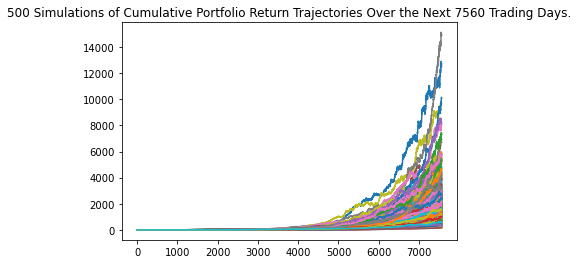

In [61]:
mc.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

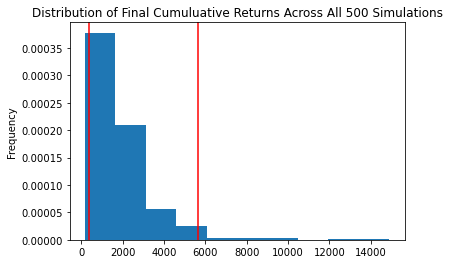

In [62]:
mc.plot_distribution()

### Calculate 30 Year Cumulative Returns

In [63]:
mc_cumulative_returns = mc.summarize_cumulative_return()
print(f'{years} year Monte Carlo summary statistics for Real Estate.')
print(mc_cumulative_returns)

30 year Monte Carlo summary statistics for Real Estate.
count             500.000000
mean             1869.817004
std              1586.100079
min               168.468518
25%               901.030229
50%              1456.893468
75%              2346.071881
max             14894.734351
95% CI Lower      343.189295
95% CI Upper     5644.267748
Name: 7560, dtype: float64


In [68]:
lower_return = mc_cumulative_returns[8] * EXAMPLE_INVESTMENT
upper_return = mc_cumulative_returns[9] * EXAMPLE_INVESTMENT

print(f"Using a 95% confidence interval, the expected returns of the "
    f"real estate portfolio is between {mc_cumulative_returns[8]: ,.2f}% "
    f"and {mc_cumulative_returns[9]: ,.2f}%. An initial example "
    f"investment of ${EXAMPLE_INVESTMENT: ,.2f} would be worth between "
    f"${lower_return: ,.2f} and ${upper_return: ,.2f} in {years} years")

Using a 95% confidence interval, the expected returns of the real estate portfolio is between  343.19% and  5,644.27%. An initial example investment of $ 10,000.00 would be worth between $ 3,431,892.95 and $ 56,442,677.48 in 30 years
